In [1]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import sklearn.preprocessing as skl_preproc
from sklearn.model_selection import train_test_split
import tensorflow as tf; tf.logging.set_verbosity(tf.logging.ERROR)
from tensorflow.keras.regularizers import l1
from tensorflow.keras import backend as K
from tqdm import tqdm

#### Dataset description

The data contains 100 features extracted from a corpus of emails. Some of the emails are spam and some are normal. Your task is to make a spam detector.

train.csv - contains 600 emails x 100 features for use training your model(s)

train_labels.csv - contains labels for the 600 training emails (1 = spam, 0 = normal)

test.csv - contains 4000 emails x 100 features. Apply your trained model(s) to these.

Participants should submit a file with each of their 4000 predictions on a separate line (in the same order as test.csv). No header is necessary. Predictions can be continuous numbers or 0/1 labels.

In [2]:
n_feat = 100
feats = ["feat_{}".format(i) for i in range(n_feat)]

n_sample = 600
train_df = pd.read_csv("../data/train.csv", names=feats, header=None)
label_df = pd.read_csv("../data/train_labels.csv", names=["label"], header=None)
train_df["data type"] = ["train" for _ in range(n_sample)]
train_df["label"] = label_df.values

n_sample = 4000
test_df = pd.read_csv("../data/test.csv", names=feats, header=None)
test_df["data type"] = ["test" for _ in range(n_sample)]
test_df["label"] = [None for _ in range(n_sample)]

data_df = pd.concat([train_df, test_df])
data_df.head()

feat_0   feat_1    feat_2   feat_3    feat_4   feat_5   feat_6   feat_7  \
0  0.097094  1.11330    45.038  0.88184  0.087009  1.04100  1.54860  3.49800   
1  0.050086  0.11158    94.080  1.76500  0.089417  4.80470  0.26742      NaN   
2  0.088447  2.36340     5.058  0.14436  0.064547  2.44400  4.25450  0.36506   
3  0.772540  0.59469       NaN  0.97515  0.015987  0.52884  1.48840  3.96100   
4  0.382410  4.81090  1955.100  0.46050  0.024453  2.02980  3.74030  4.22810   

    feat_8    feat_9  ...   feat_92   feat_93   feat_94   feat_95  feat_96  \
0  1.85780  0.009673  ...  0.061607  0.003161  0.036038  0.084500   2.4517   
1  0.56473  0.035123  ...  0.075432  0.010869  0.063972  0.079892   1.9795   
2  1.86090  0.009759  ...  0.046505       NaN  0.084066  0.064829   3.3087   
3  4.80630  0.048617  ...  0.065028  0.036862  0.010010  0.020709   2.5237   
4  2.42920  0.156830  ...  1.001100  0.065750  0.043547  0.629430   4.6262   

   feat_97   feat_98   feat_99  data type  label  
0   3.3373  0.065201  0.091158      train      0  
1   3.5064  0.072132  0.091950      train      1  
2   2.9969  0.064328  0.036793      train      0  
3   2.1711  0.080865  0.081553      train      0  
4   3.1947       NaN  0.187180      train      1  

[5 rows x 102 columns]

#### Filling gaps

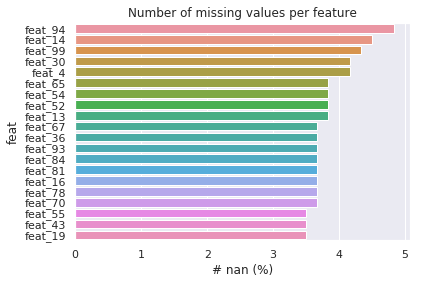

In [3]:
nan_dic = {"feat": [], "# nan (%)": []}
for feat in data_df.columns:
    if "feat" in feat:
        nan_dic["feat"].append(feat)
        n_nan = data_df.loc[data_df["data type"] == "train"][feat].isna().sum()
        n_tot = data_df.loc[data_df["data type"] == "train"][feat].shape[0]
        nan_dic["# nan (%)"].append(n_nan*100./n_tot)
nan_df = pd.DataFrame(nan_dic)
nan_df = nan_df.sort_values(by="# nan (%)", ascending=False)
sns.barplot(data=nan_df.iloc[0:20], x="# nan (%)", y="feat")
plt.title("Number of missing values per feature")

# As shown below, the number of missing values is less than 5\% for the worst case.
# Then, my 1st attempt is simply replacing them by the mode.
for feat in data_df.columns:
    if "feat" in feat:
        new_v = data_df.loc[data_df["data type"] == "train"][feat].dropna(axis=0).mode()[0]
        data_df[feat].fillna(new_v, inplace=True)

In [4]:
data_df.head()

feat_0   feat_1     feat_2   feat_3    feat_4   feat_5   feat_6   feat_7  \
0  0.097094  1.11330    45.0380  0.88184  0.087009  1.04100  1.54860  3.49800   
1  0.050086  0.11158    94.0800  1.76500  0.089417  4.80470  0.26742  1.48770   
2  0.088447  2.36340     5.0580  0.14436  0.064547  2.44400  4.25450  0.36506   
3  0.772540  0.59469     6.0078  0.97515  0.015987  0.52884  1.48840  3.96100   
4  0.382410  4.81090  1955.1000  0.46050  0.024453  2.02980  3.74030  4.22810   

    feat_8    feat_9  ...   feat_92   feat_93   feat_94   feat_95  feat_96  \
0  1.85780  0.009673  ...  0.061607  0.003161  0.036038  0.084500   2.4517   
1  0.56473  0.035123  ...  0.075432  0.010869  0.063972  0.079892   1.9795   
2  1.86090  0.009759  ...  0.046505  0.027065  0.084066  0.064829   3.3087   
3  4.80630  0.048617  ...  0.065028  0.036862  0.010010  0.020709   2.5237   
4  2.42920  0.156830  ...  1.001100  0.065750  0.043547  0.629430   4.6262   

   feat_97   feat_98   feat_99  data type  label  
0   3.3373  0.065201  0.091158      train      0  
1   3.5064  0.072132  0.091950      train      1  
2   2.9969  0.064328  0.036793      train      0  
3   2.1711  0.080865  0.081553      train      0  
4   3.1947  0.000553  0.187180      train      1  

[5 rows x 102 columns]

#### Data scalling

In [5]:
# _df = pd.melt(data_df, value_vars=feats)
# grid = sns.FacetGrid(_df, col="variable", col_wrap=5, aspect=1.0, sharex=False, sharey=False)
# grid.map(sns.distplot, "value")

# Data seems "nicely distributed". So, no trick here but standard scalling.
scaler = skl_preproc.StandardScaler()
scaler.fit(data_df.loc[data_df["data type"] == "train"][feats])
data_df[feats] = scaler.transform(data_df[feats])

# _df = pd.melt(data_df, value_vars=feats)
# grid = sns.FacetGrid(_df, col="variable", col_wrap=5, aspect=1.0, sharex=False, sharey=False)
# grid.map(sns.distplot, "value")

#### Correlation

In [6]:
def get_feats_drop(df, feats, threshold=0.5):
    corr = df[feats].corr()
    drop_feats = []
    for feat_i in feats:
        for feat_j in feats:
            if feat_i != feat_j:
                if np.abs(corr[feat_i][feat_j]) > threshold and \
                feat_i not in drop_feats and feat_j not in drop_feats:
                    drop_feats.append(feat_i)
    return drop_feats

# of dropped features = 2


Text(0.5, 1.0, 'After dropping highly correlated features')

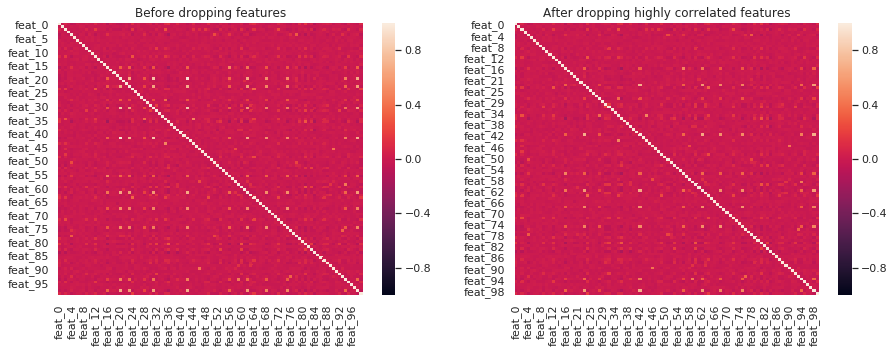

In [7]:
corr = data_df[feats].corr()
fig = plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.heatmap(corr, vmin=-1, vmax=1); plt.title("Before dropping features")
#
drop_feats = get_feats_drop(data_df, feats, threshold=0.80)
print("# of dropped features = {}".format(len(drop_feats)))
data_df.drop(drop_feats, axis=1, inplace=True)
_ = [feats.remove(feat) for feat in drop_feats]
#
corr = data_df[feats].corr()
plt.subplot(1, 2, 2)
sns.heatmap(corr, vmin=-1, vmax=1); plt.title("After dropping highly correlated features")

#### Features significance

In [8]:
# use xgboost library (it computs the entropy of variables towards the output)
X_train, X_test, Y_train, Y_test = \
    train_test_split(data_df.loc[data_df["data type"] == "train", feats].values, 
                     data_df.loc[data_df["data type"] == "train"]["label"].values,
                     test_size=0.2, random_state=0)
xgb = XGBClassifier(learning_rate=1e-3, max_depth=50, n_estimators=500)
xgb.fit(X_train, Y_train)
imp = pd.DataFrame({"feat": feats, "importance": xgb.feature_importances_})
print("Most important features: \n{}".format(imp.sort_values(by="importance", ascending=False).head()))
print("*"*50)
print("Least important features: \n{}".format(imp.sort_values(by="importance", ascending=True).head()))
print("*"*50)
print("# of insignificant features = {}".format(imp.loc[imp.importance <= 0.02].shape[0]))
drop_feats = list(imp.loc[imp.importance <= 0]["feat"].values)
data_df.drop(drop_feats, axis=1, inplace=True)
_ = [feats.remove(feat) for feat in drop_feats]

Most important features: 
       feat  importance
12  feat_12    0.221279
77  feat_79    0.144235
42  feat_44    0.052524
51  feat_53    0.051313
29  feat_30    0.037620
**************************************************
Least important features: 
       feat  importance
41  feat_43         0.0
72  feat_74         0.0
35  feat_37         0.0
4    feat_4         0.0
43  feat_45         0.0
**************************************************
# of insignificant features = 89


#### ML algorithm

In [9]:
class MyCallBack(tf.keras.callbacks.Callback):
    def __init__(self, acc=0.9, verbose=0):
        self.acc = acc
        self.verbose = verbose
        return;
    
    def on_epoch_end(self, epoch, log={}):
        if log.get("acc") >= self.acc:
            if self.verbose > 0:
                print("Accuraty >= {}%. Training is ceased.".format(self.acc*100.))
            self.model.stop_training = True
        return;
    
def swish(x):
    return K.sigmoid(x) * x
# tf.nn.relu

class MyNN():
    def __init__(self, lr=1.e-2, momentum=1.0, lamb=0.1, callbacks=None):
        self.callbacks = callbacks
        self.model = tf.keras.models.Sequential()
        self.model.add(tf.keras.layers.Dense(256, activation=swish, 
                                             kernel_initializer="random_uniform", bias_initializer="zeros",
                                             kernel_regularizer=l1(lamb), bias_regularizer=l1(lamb)))
        self.model.add(tf.keras.layers.Dropout(rate=0.25))
        self.model.add(tf.keras.layers.BatchNormalization())
        self.model.add(tf.keras.layers.Dense(256, activation=swish, 
                                             kernel_initializer="random_uniform", bias_initializer="zeros",
                                             kernel_regularizer=l1(lamb), bias_regularizer=l1(lamb)))
        self.model.add(tf.keras.layers.Dropout(rate=0.25))
        self.model.add(tf.keras.layers.BatchNormalization())
        self.model.add(tf.keras.layers.Dense(256, activation=swish, 
                                             kernel_initializer="random_uniform", bias_initializer="zeros",
                                             kernel_regularizer=l1(lamb), bias_regularizer=l1(lamb)))
        self.model.add(tf.keras.layers.Dropout(rate=0.25))
        self.model.add(tf.keras.layers.BatchNormalization())
        self.model.add(tf.keras.layers.Dense(256, activation=swish, 
                                             kernel_initializer="random_uniform", bias_initializer="zeros",
                                             kernel_regularizer=l1(lamb), bias_regularizer=l1(lamb)))
        self.model.add(tf.keras.layers.Dropout(rate=0.25))
        self.model.add(tf.keras.layers.BatchNormalization())
        self.model.add(tf.keras.layers.Dense(1, activation=tf.nn.sigmoid, 
                                             kernel_initializer="random_uniform", bias_initializer="zeros"))
        sgd = tf.keras.optimizers.SGD(lr=lr, momentum=momentum, decay=0.0, nesterov=False)
        self.model.compile(optimizer=sgd, loss="binary_crossentropy", metrics=["acc"])
        return;
    
    def fit(self, X, Y, epochs=100, verbose=0):
        batch_size = X.shape[0]
        self.model.fit(X, Y, epochs=epochs, batch_size=batch_size, callbacks=self.callbacks, verbose=verbose)
        return;
    
    def evaluate(self, X, Y):
        Y_pred = np.round(self.model.predict(X))
        acc = np.sum(Y_pred[:, 0] == Y)/Y_pred.shape[0]
        return round(acc, 4)

    def predict(self, X):
        return np.round(self.model.predict(X))
    
    def _get_model(self):
        return self.model

In [10]:
X = data_df.loc[data_df["data type"] == "train", feats].values
Y = data_df.loc[data_df["data type"] == "train"]["label"].values
X_train, _X, Y_train, _Y = train_test_split(X, Y, test_size=0.4, random_state=0)
X_dev, X_test, Y_dev, Y_test = train_test_split(_X, _Y, test_size=0.5, random_state=0)

In [11]:
params = {"learn_rate": [10.**-i for i in range(5)], 
          "momentum": np.arange(0.0, 2, 0.1), 
          "lambda": np.arange(0.0, 0.1, 0.01)}
results = {"learn_rate": [], "momentum": [], "lambda": [], "acc_train": [], "acc_dev": []}

for _ in tqdm(range(100)):
    lr = np.random.choice(params["learn_rate"])
    momentum = np.random.choice(params["momentum"])
    lamb = np.random.choice(params["lambda"])
    nn = MyNN(lr=lr, momentum=momentum, lamb=lamb)
    nn.fit(X_train, Y_train, epochs=250, verbose=0)
    acc_train = nn.evaluate(X_train, Y_train)
    acc_dev = nn.evaluate(X_dev, Y_dev)
    results["learn_rate"].append(lr)
    results["momentum"].append(momentum)
    results["lambda"].append(lamb)
    results["acc_train"].append(acc_train)
    results["acc_dev"].append(acc_dev)

100%|██████████| 100/100 [1:06:48<00:00, 81.02s/it]


In [12]:
idx = np.argmax(results["acc_dev"])
lr = results["learn_rate"][idx]
momentum = results["momentum"][idx]
lamb = results["lambda"][idx]
acc_train = results["acc_train"][idx]
acc_dev = results["acc_dev"][idx]

nn = MyNN(lr=lr, momentum=momentum, lamb=lamb)
nn.fit(X_train, Y_train, epochs=1000, verbose=0)
acc_test = nn.evaluate(X_test, Y_test)

print("Acc dev = {}".format(acc_dev))
print("Acc test = {}".format(acc_test))

Acc dev = 0.8833
Acc test = 0.85


In [16]:
nn = MyNN(lr=1.e-1, momentum=0.0, lamb=0.0)
nn.fit(X_train, Y_train, epochs=1000, verbose=0)
acc_train = nn.evaluate(X_train, Y_train)
acc_dev = nn.evaluate(X_dev, Y_dev)
acc_test = nn.evaluate(X_test, Y_test)
print("acc train = {}, acc dev = {}, acc test = {}".format(acc_train, acc_dev, acc_test))

acc train = 1.0, acc dev = 0.8333, acc test = 0.85




  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:17<05:23, 17.05s/it]

 10%|█         | 2/20 [00:39<05:34, 18.57s/it]

 15%|█▌        | 3/20 [01:05<05:57, 21.01s/it]

 20%|██        | 4/20 [01:38<06:32, 24.51s/it]

 25%|██▌       | 5/20 [02:17<07:10, 28.70s/it]

 30%|███       | 6/20 [03:01<07:48, 33.47s/it]

 35%|███▌      | 7/20 [03:52<08:23, 38.72s/it]

 40%|████      | 8/20 [04:49<08:49, 44.12s/it]

 45%|████▌     | 9/20 [05:53<09:11, 50.14s/it]

 50%|█████     | 10/20 [07:03<09:20, 56.06s/it]

 55%|█████▌    | 11/20 [08:21<09:23, 62.56s/it]

 60%|██████    | 12/20 [09:44<09:09, 68.66s/it]

 65%|██████▌   | 13/20 [11:13<08:44, 74.95s/it]

 70%|███████   | 14/20 [12:49<08:08, 81.37s/it]

 75%|███████▌  | 15/20 [14:32<07:19, 87.85s/it]

 80%|████████  | 16/20 [16:22<06:17, 94.47s/it]

 85%|████████▌ | 17/20 [18:19<05:03, 101.16s/it]

 90%|█████████ | 18/20 [20:23<03:35, 107.90s/it]

 95%|█████████▌| 19/20 [22:34<01:54, 114.77s/it]

100%|██████████| 20/20 [24:51<00:

Text(0.5, 0, '# of epochs')

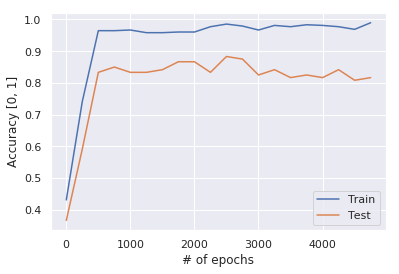

In [64]:
epoch_size = np.arange(1, 5000, 250)
accuracy_train = []
accuracy_test = []
for epochs in tqdm(epoch_size):
#     nn = MyNN(callbacks=[MyCallBack(acc=0.99)])
    nn = MyNN(lr=1.e-3, momentum=1., lamb=0.01)
    nn.fit(X_train, Y_train, epochs=epochs, verbose=0)
    acc_train = nn.evaluate(X_train, Y_train)
    acc_test = nn.evaluate(X_test, Y_test)
    accuracy_train.append(acc_train)
    accuracy_test.append(acc_test)
plt.plot(epoch_size, accuracy_train, epoch_size, accuracy_test)
plt.legend(["Train", "Test"])
plt.ylabel("Accuracy [0, 1]"); plt.xlabel("# of epochs")